In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

In [13]:
class PartialModel:
    # Assumed that number of actions is same for all states which is true for the machine replacement problem
    def __init__(self, num_states, num_actions, M, quality_interpolation_factor, quality_adjustment_coeff):
        self.num_states = num_states
        self.num_actions = num_actions
        self.T = np.ones((num_states, num_actions, num_states)) / num_states
        self.R = np.zeros((num_states, num_actions))
        self.N = np.zeros((num_states, num_actions))
        self.M = M
        self.quality = 0 # Initial quality
        self.quality_interpolation_factor = quality_interpolation_factor
        self.quality_adjustment_coeff = quality_adjustment_coeff
        self.R_max = 0
        self.R_min = 0

    def update_quality(self, state, action, reward, next_state):
        c = self.N[state, action] / self.M
        delta_R = (reward - self.R[state, action]) / (self.N[state, action] + 1)
        self.R_max = max(self.R_max, self.R[state, action])
        self.R_min = min(self.R_min, self.R[state, action])
        e_R = 1 - 2*delta_R*delta_R/(self.R_max - self.R_min + 1e-5)
        e_T = 1
        for k in range(self.num_states):
            delta_T = (1 - self.T[state, action, k]) / (self.N[state, action] + 1) if k == next_state else -self.T[state, action, k] / (self.N[state, action] + 1)
            e_T -= delta_T*delta_T*(self.N[state, action]+1)*(self.N[state, action]+1)
        e = c*(self.quality_interpolation_factor*e_R + (1-self.quality_interpolation_factor)*e_T)
        self.quality = (1 - self.quality_adjustment_coeff) * self.quality + self.quality_adjustment_coeff * e

    def update_model(self, state, action, reward, next_state):
        delta_R = (reward - self.R[state, action]) / (self.N[state, action] + 1)
        self.R[state, action] += delta_R

        for k in range(self.num_states):
            delta_T = (1 - self.T[state, action, k]) / (self.N[state, action] + 1) if k == next_state else -self.T[state, action, k] / (self.N[state, action] + 1)
            self.T[state, action, k] += delta_T
        self.N[state, action] = min(self.N[state, action] + 1, self.M)

    def get_quality(self):
        return self.quality

    def get_reward(self, state, action):
        return self.R[state, action]

    def get_next_state(self, state, action):
        return np.random.choice(self.num_states, p=self.T[state, action])

In [14]:
class DynaAgent:
    def __init__(self, state_space_size, action_space_size, model,
                 learning_rate=0.1, discount_factor=0.9, epsilon=0.1,
                 planning_steps=50000):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.planning_steps = planning_steps
        self.model = model

        self.q_table = np.zeros((state_space_size, action_space_size))
        self.visited_state_actions = set()  # Track visited (state, action) pairs

    def is_visited(self, state, action):
        if (state, action) in self.visited_state_actions:
            return True
        return False

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_space_size)
        else:
            return np.argmin(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        transition_probs = self.model.T[state, action]
        rewards = self.model.R[state, action]
        expected_q = 0.0
        for ns in range(self.state_space_size):
            best_next_action = np.argmin(self.q_table[ns])
            expected_q += transition_probs[ns] * (rewards + self.gamma * self.q_table[ns, best_next_action])
        self.q_table[state, action] = expected_q

    def planning(self):
        for _ in range(self.planning_steps):
            if not self.visited_state_actions:
                break

            state, action = random.choice(list(self.visited_state_actions))

            next_state = np.random.choice(self.model.T.shape[2], p=self.model.T[state, action])
            reward = self.model.R[state, action]

            self.update_q_table(state, action, reward, next_state)

    def learn(self, state, action, reward, next_state):
        self.update_q_table(state, action, reward, next_state)

        self.planning()


# RLCD on Machine Replacement

In [15]:
num_states = 10
num_actions = 2
max_restarts = 10
epsilon = 1

In [16]:
def linear_cost_function(state, action):
    if action == 0:
        return 5 * state + 2
    else:
        return 50


def quadratic_cost_function(state, action):
    if action == 0:
        return state ** 2 + 10
    else:
        return 60


def create_simple_transition_matrix(num_states, failure_rate_factor=0.1):
    num_actions = 2
    transition_probs = np.zeros((num_states, num_actions, num_states))

    for state in range(num_states):
        if state < num_states - 1:
            # Probability of aging normally (state -> state + 1)
            failure_prob = min(failure_rate_factor * state, 0.8)
            age_prob = 1.0 - failure_prob

            transition_probs[state, 1, state + 1] = age_prob  # Age normally
            transition_probs[state, 1, 0] = failure_prob      # Fail and replace
        else:
            # At max age, machine must be replaced
            transition_probs[state, 1, 0] = 1.0

        # Action 0: Replace machine (always go to state 0)
        transition_probs[state, 0, 0] = 1.0

    return transition_probs


def create_complex_transition_matrix(num_states):
    num_actions = 2
    transition_probs = np.zeros((num_states, num_actions, num_states))

    for state in range(num_states):
        # Action 1: Keep machine
        if state < num_states - 1:
            # Multiple possible outcomes
            immediate_failure_prob = 0.05 * state  # Immediate failure
            major_failure_prob = 0.03 * state      # Major failure (replace)
            normal_aging_prob = 1.0 - immediate_failure_prob - major_failure_prob

            transition_probs[state, 1, 0] = immediate_failure_prob + major_failure_prob
            transition_probs[state, 1, state + 1] = normal_aging_prob
        else:
            # At max age
            transition_probs[state, 1, 0] = 1.0

        # Action 0: Replace machine
        transition_probs[state, 0, 0] = 1.0

    return transition_probs

def create_custom_cost_function(operating_costs, replacement_cost):
    def cost_function(state, action):
        if action == 0:  # Replace machine
            return replacement_cost
        else:  # Keep machine
            return operating_costs[state]

    return cost_function

In [17]:
class MachineReplacementEnv:
    def __init__(self, cost_function, transition_probs, num_states, num_actions):
        self.cost_function = cost_function
        self.transition_probs = np.array(transition_probs)
        self.num_states = num_states
        self.num_actions = num_actions
        self.state = 0

        assert self.transition_probs.shape[0] == num_states
        assert self.transition_probs.shape[2] == num_states

        prob_sums = np.sum(self.transition_probs, axis=2)
        assert np.allclose(prob_sums, 1.0), "Transition probabilities must sum to 1"

    def reset(self):
        self.state = np.random.randint(0, self.num_states)
        return self.state

    def step(self, action):
        cost = self.cost_function(self.state, action)
        reward = cost

        next_state_probs = self.transition_probs[self.state, action, :]
        next_state = np.random.choice(self.num_states, p=next_state_probs)

        self.state = next_state

        done = False

        info = {
            'cost': cost,
            'transition_prob': next_state_probs[next_state]
        }

        return self.state, reward, done, info

    def get_state_space_size(self):
        return self.num_states

    def get_action_space_size(self):
        return self.num_actions

In [18]:
def train_dyna_agent_custom(model, agent, num_states, num_actions,
                           episodes=1000, max_steps_per_episode=50):

    def model_cost_function(state, action):
        return model.R[state, action]

    transition_probs = model.T

    env = MachineReplacementEnv(model_cost_function, transition_probs, num_states, num_actions)

    episode_rewards = []
    episode_lengths = []
    avg_rewards = []

    model.epsilon = 1.0

    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        for _ in range(max_steps_per_episode):
            action = agent.choose_action(state)

            next_state, reward, done, _ = env.step(action)

            agent.learn(state, action, reward, next_state)

            total_reward += reward
            state = next_state
            steps += 1

            if done:
                break

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        avg_rewards.append(np.mean(episode_rewards[-100:]))

        agent.epsilon = max(0.01, agent.epsilon * 0.995)

    return episode_rewards, episode_lengths, avg_rewards, agent.q_table

In [19]:
# RLCD on Machine Replacement
m_curr = PartialModel(num_states, num_actions, M=100, quality_interpolation_factor=0.1, quality_adjustment_coeff=0.5)
M_models = [m_curr]
E_min = -0.1 # needs tuning, with current scenario, might have to take average over a couple episodes to get a switch after a change in environment
max_steps = 10000
best_model_quality = []

operating_costs_1 = [5, 8, 13, 21, 34, 55, 65, 75, 85, 95]
custom_cost_func_1 = create_custom_cost_function(operating_costs_1, replacement_cost=40)
operating_costs_2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
custom_cost_func_2 = create_custom_cost_function(operating_costs_2, replacement_cost=40)

print("Custom Operating Costs: ", custom_cost_func_1)
print("Custom Operating Costs: ", custom_cost_func_2)

# Custom transition matrix (high failure rate after state 3)
custom_transitions_1 = create_simple_transition_matrix(num_states, failure_rate_factor=0.2)
custom_transitions_2 = create_complex_transition_matrix(num_states)

print("Custom TPM: ", custom_transitions_1)
print("Custom TPM: ", custom_transitions_2)

agent = DynaAgent(
    state_space_size=num_states,
    action_space_size=num_actions,
    model=m_curr,
    learning_rate=0.1,
    discount_factor=0.9,
    epsilon=0.1,
)

env1 = MachineReplacementEnv(custom_cost_func_1, custom_transitions_1, num_states, num_actions)

env2 = MachineReplacementEnv(custom_cost_func_2, custom_transitions_2, num_states, num_actions)

env = env1
state = 0

tracking_rewards = []
q_tables_final = []

for step in tqdm(range(max_steps)):
    if step == max_steps // 2:
        env = env2
        print("Environment changed at step", step)

    if np.random.rand() < epsilon:
        action = np.random.choice(num_actions)
    else:
        action = np.argmin(q_table[state, :])

    next_state, reward, done, info = env.step(action)

    if step % 1000 == 0:
        print( f"Step {step}: State {state}, Action {action}, Reward {reward}, Next State {next_state}, Done {done}" )

    exp_state = state
    exp_action = action
    exp_reward = reward
    exp_next_state = next_state

    tracking_rewards.append(reward)

    for m in M_models:
        m.update_quality(exp_state, exp_action, exp_reward, exp_next_state)

    m_best = max(M_models, key=lambda m: m.get_quality())
    best_model_quality.append(m_best.get_quality())

    if m_best.get_quality() < E_min:
        print(f"Creating new model at step {step} with quality {m_best.get_quality()} due to change in environment")
        m_curr = PartialModel(num_states, num_actions, M=100, quality_interpolation_factor=0.1, quality_adjustment_coeff=0.5)
        M_models.append(m_curr)
    else:
        m_curr = m_best

    m_curr.update_model(exp_state, exp_action, exp_reward, exp_next_state)

    state = next_state

    episode_rewards, episode_lengths, avg_rewards, q_table = train_dyna_agent_custom(m_curr, agent, num_states, num_actions, episodes=100, max_steps_per_episode=50)
    q_tables_final.append(q_table.copy())

Custom Operating Costs:  <function create_custom_cost_function.<locals>.cost_function at 0x700f6d530ea0>
Custom Operating Costs:  <function create_custom_cost_function.<locals>.cost_function at 0x700f6d5c7e20>
Custom TPM:  [[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.2 0.  0.8 0.  0.  0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.4 0.  0.  0.6 0.  0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.6 0.  0.  0.  0.4 0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.2 0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.2 0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.  0.2 0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.  0.  0.2 0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.

  0%|          | 2/10000 [00:00<14:35, 11.42it/s]

Step 0: State 0, Action 1, Reward 5, Next State 1, Done False


 10%|█         | 1001/10000 [01:27<13:34, 11.05it/s]

Step 1000: State 0, Action 1, Reward 5, Next State 1, Done False


 20%|██        | 2001/10000 [02:51<10:58, 12.14it/s]

Step 2000: State 0, Action 1, Reward 5, Next State 1, Done False


 30%|███       | 3001/10000 [04:16<09:36, 12.13it/s]

Step 3000: State 0, Action 1, Reward 5, Next State 1, Done False


 40%|████      | 4001/10000 [05:41<08:36, 11.62it/s]

Step 4000: State 1, Action 1, Reward 8, Next State 2, Done False


 50%|█████     | 5001/10000 [07:04<06:45, 12.33it/s]

Environment changed at step 5000
Step 5000: State 0, Action 0, Reward 40, Next State 0, Done False


 60%|██████    | 6001/10000 [08:28<05:41, 11.72it/s]

Step 6000: State 0, Action 1, Reward 1, Next State 1, Done False


 70%|███████   | 7001/10000 [09:52<04:19, 11.57it/s]

Step 7000: State 1, Action 0, Reward 40, Next State 0, Done False


 80%|████████  | 8001/10000 [11:16<02:43, 12.23it/s]

Step 8000: State 4, Action 0, Reward 40, Next State 0, Done False


 90%|█████████ | 9001/10000 [12:41<01:22, 12.08it/s]

Step 9000: State 0, Action 1, Reward 1, Next State 1, Done False


100%|██████████| 10000/10000 [14:07<00:00, 11.80it/s]


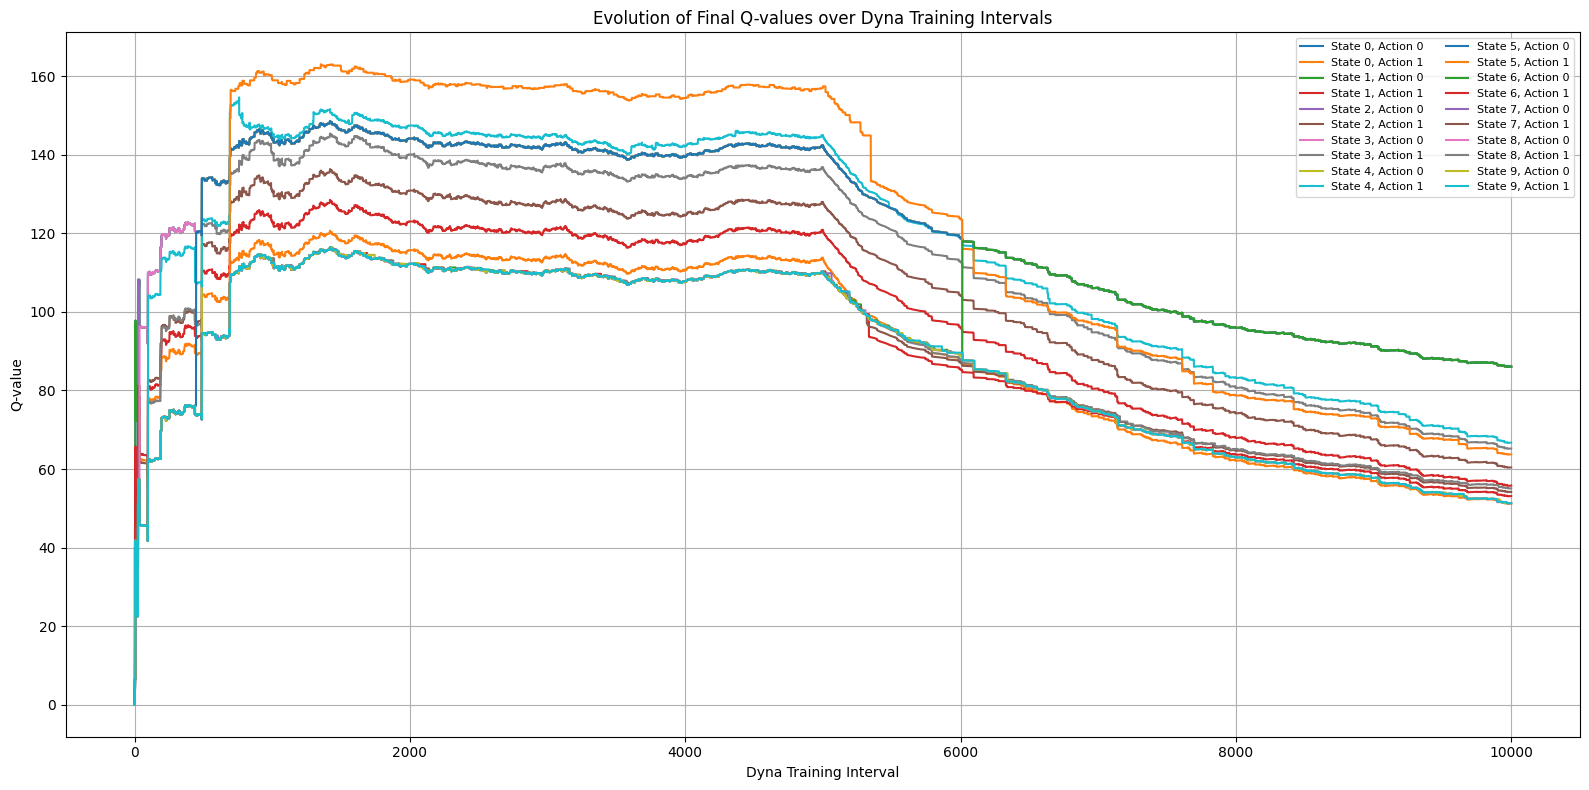

In [20]:
q_tables_final_np = np.array(q_tables_final)
num_intervals = q_tables_final_np.shape[0]
plt.figure(figsize=(16, 8))
for state in range(num_states):
    for action in range(num_actions):
        plt.plot(range(num_intervals), q_tables_final_np[:, state, action], label=f"State {state}, Action {action}")
plt.xlabel("Dyna Training Interval")
plt.ylabel("Q-value")
plt.title("Evolution of Final Q-values over Dyna Training Intervals")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

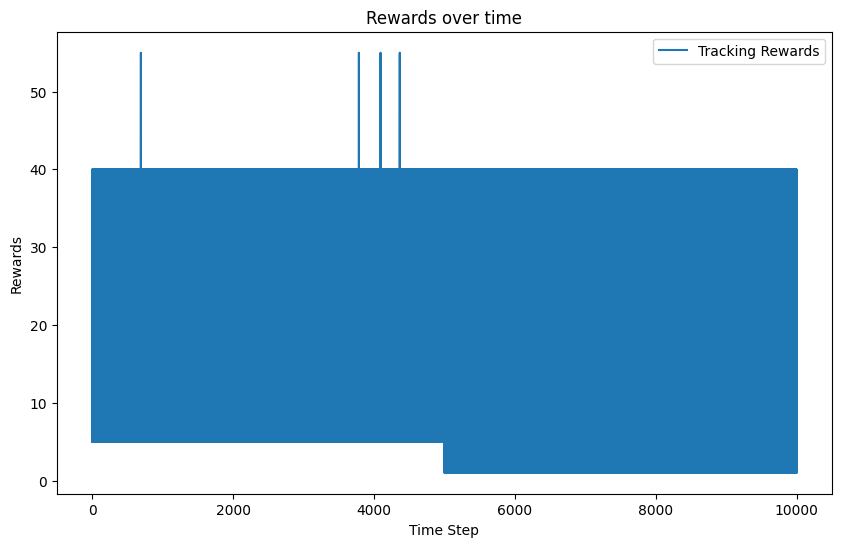

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(tracking_rewards, label='Tracking Rewards')
plt.xlabel('Time Step')
plt.ylabel('Rewards')
plt.title('Rewards over time')
plt.legend()
plt.show()

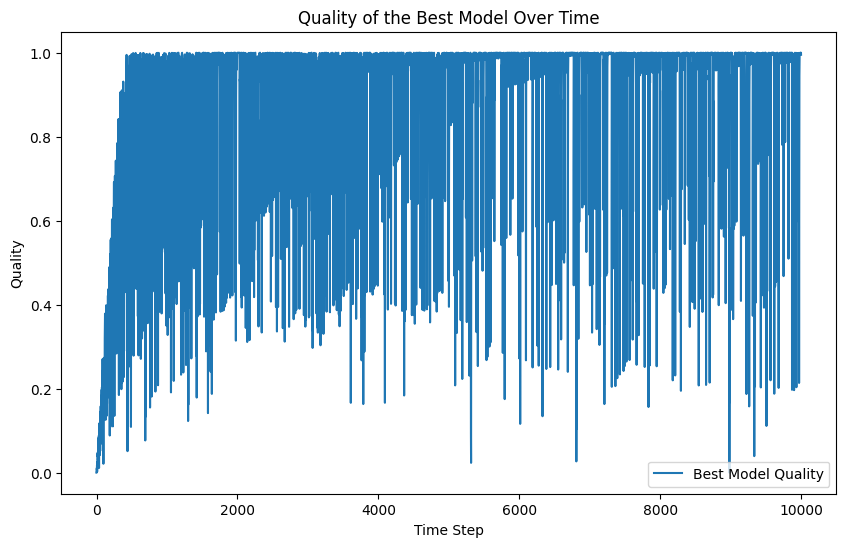

In [22]:
# plotting the quality of the best model over time
plt.figure(figsize=(10, 6))
plt.plot(best_model_quality, label='Best Model Quality')
plt.xlabel('Time Step')
plt.ylabel('Quality')
plt.title('Quality of the Best Model Over Time')
plt.legend()
plt.show()